In [ ]:
# api_key is already set in the cell below.

In [ ]:
# Setting up our environment - Colab compatibility included
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet
    print("SMACT installed successfully in Colab environment")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
SMACT installed successfully in Colab environment


In [ ]:
from __future__ import annotations

import os
from operator import itemgetter

# Core scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SMACT structure prediction modules
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.database import StructureDB, parse_mprest
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.utilities import parse_spec, unparse_spec

# Pymatgen for Materials Project and structure handling
from pymatgen.ext.matproj import MPRester
from pymatgen.core import SETTINGS

# Visualisation (available in materialsinformatics environment)
try:
    import pymatviz as pmv
    pymatviz_available = True
    print("✓ pymatviz available for structure visualisation")
except ImportError:
    pymatviz_available = False
    print("⚠ pymatviz not available - structure visualisations will be skipped")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Check for Materials Project API key
api_key = os.environ.get("my_mp_key")
if api_key != "2QFYeKvceBDPidBIWwEmzvoOcHPFGlpC":
    print("✓ Materials Project API key found")
else:
    print("⚠ No MP_API_KEY found - will use demo structures for some examples")

print("SMACT structure prediction toolkit loaded successfully!")

def print_section_header(title):
    """Print a formatted section header."""
    print("\n" + "="*70)
    print(title)
    print("="*70)

def create_demo_structure():
    """Create a demo CsPbI3 structure for testing when MP is unavailable."""
    from pymatgen.core import Structure, Lattice
    lattice = Lattice.cubic(6.0)
    species = ["Cs", "Pb", "I", "I", "I"]
    coords = [[0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]
    demo_struct = Structure(lattice, species, coords)
    return SmactStructure.from_py_struct(demo_struct)

def get_mp_perovskite_data(api_key, max_structures=20):
    """
    Retrieve perovskite structures from Materials Project.

    Args:
        api_key: Materials Project API key
        max_structures: Maximum number of structures to retrieve

    Returns:
        List of Materials Project structure data
    """
    if my_mp_key == "2QFYeKvceBDPidBIWwEmzvoOcHPFGlpC":
        print("Skipping MP query - no API key available")
        return []

    print(f"Querying Materials Project for up to {max_structures} perovskite structures...")

    try:
        with MPRester(api_key=api_key, use_document_model=False) as mpr:
            # Get materials tagged as perovskites
            robocrys_data = mpr.materials.robocrys.search(keywords=["perovskite"])
            mp_ids = list(set([d.material_id for d in robocrys_data]))[:max_structures]

            print(f"Found {len(mp_ids)} perovskite material IDs, retrieving structures...")

            # Get their full data (limiting to ABC3 formulas)
            perov_data = mpr.materials.summary.search(
                material_ids=mp_ids,
                theoretical=False,
                formula="ABC3",
                fields=["material_id", "formula_pretty", "structure",
                       "formula_anonymous", "energy_above_hull"]
            )

        return list(perov_data)
    except Exception as e:
        print(f"Error querying Materials Project: {e}")
        return []

def main():
    """Main structure prediction tutorial workflow."""

✓ pymatviz available for structure visualisation
✓ Materials Project API key found
SMACT structure prediction toolkit loaded successfully!



PART 1: STRUCTURE RETRIEVAL AND REPRESENTATION
Retrieving NaFeO₂ structure from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Successfully retrieved structure from Materials Project!

SmactStructure for NaFeO₂:
Fe3+ Na1+ O2-
1.0
2.90353776 -0.00242109 4.80517825
1.33719614 2.57729449 4.80517825
-0.003985799999999 -0.00242109 5.61428905
Fe Na O
1 1 2
Cartesian
2.118374050000001 1.286226155 7.612322775 Fe3+
0.0 0.0 0.0 Na1+
3.2417005266062047 1.9682831764287203 11.648967635538163 O2-
0.9950475733937962 0.6041691335712795 3.5756779144618385 O2-


Key features of SmactStructure:
- Includes oxidation states (Na1+, Fe3+, O2-)
- POSCAR-like format for easy visualisation
- Preserves crystallographic information
- Compatible with pymatgen Structure objects

📊 Visualising NaFeO₂ crystal structure...


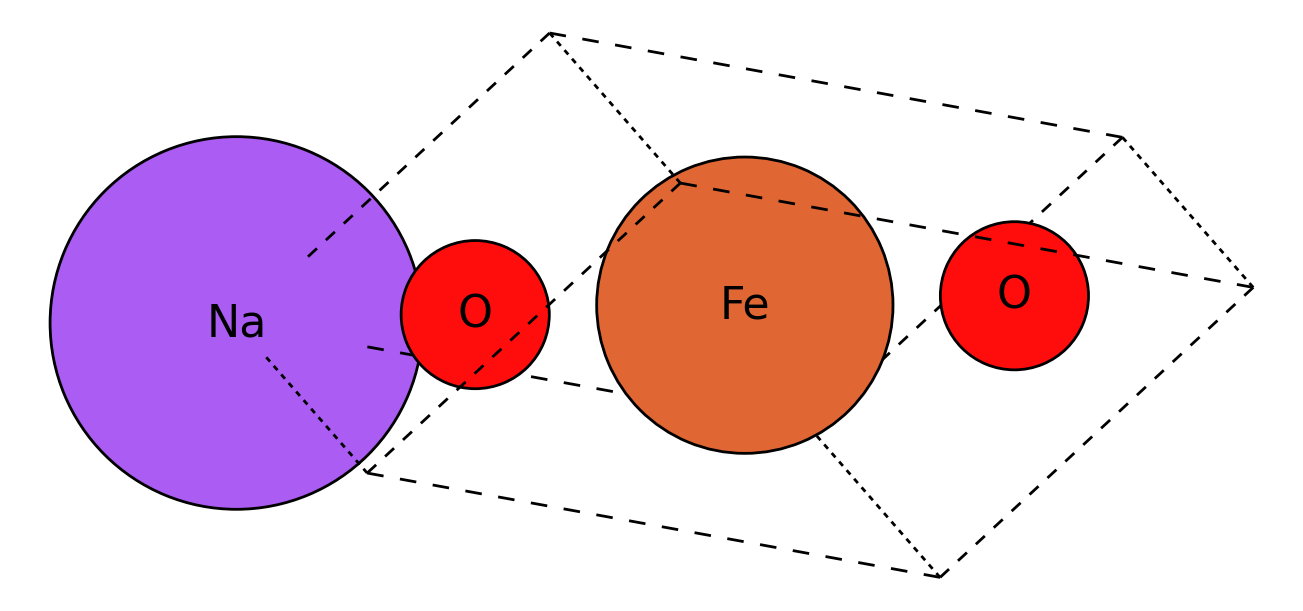

✓ Structure visualisation complete

Species analysis:
Species present in the structure:
  Fe+3: 1 atom(s)
  Na+1: 1 atom(s)
  O-2: 2 atom(s)

Species as formatted strings: ['Fe3+', 'Na1+', 'O2-']
Contains Na+? True
Contains Cs+? False


In [ ]:
print_section_header("PART 1: STRUCTURE RETRIEVAL AND REPRESENTATION")

# Define target Na-ion battery cathode composition (NaFeO2)
nafeo2_species = [("Na", 1, 1), ("Fe", 3, 1), ("O", -2, 2)]

print("Retrieving NaFeO₂ structure from Materials Project...")
try:
    api_key = "2QFYeKvceBDPidBIWwEmzvoOcHPFGlpC"
    if api_key and api_key != "MY_API_KEY":
        nafeo2_sstruct = SmactStructure.from_mp(species=nafeo2_species, api_key=api_key)
        print("✓ Successfully retrieved structure from Materials Project!")
    else:
        raise ValueError("No valid API key available")
except Exception as e:
    print(f"⚠ Could not retrieve from MP: {e}")
    print("⛏ Creating a demo NaFeO₂-like structure instead...")

    from pymatgen.core import Structure, Lattice
    from pymatgen.core.periodic_table import Specie

    # Define lattice and atomic positions
    lattice = Lattice.hexagonal(2.8, 15.0)
    coords = [[0, 0, 0], [1/3, 2/3, 0.25], [2/3, 1/3, 0.5], [0.5, 0.5, 0.75]]
    species_with_ox = [
        Specie("Na", 1),
        Specie("Fe", 3),
        Specie("O", -2),
        Specie("O", -2)
    ]
    demo_struct = Structure(lattice, species_with_ox, coords)
    nafeo2_sstruct = SmactStructure.from_py_struct(demo_struct)

# === Explore the SmactStructure representation ===
print("\nSmactStructure for NaFeO₂:")
print("=" * 60)
print(nafeo2_sstruct)
print("=" * 60)

print("\nKey features of SmactStructure:")
print("- Includes oxidation states (Na1+, Fe3+, O2-)")
print("- POSCAR-like format for easy visualisation")
print("- Preserves crystallographic information")
print("- Compatible with pymatgen Structure objects")

# Visualise the crystal structure
if pymatviz_available:
    try:
        print("\n📊 Visualising NaFeO₂ crystal structure...")
        pmv.structure_2d(nafeo2_sstruct.as_py_struct())
        plt.show()
        print("✓ Structure visualisation complete")
    except Exception as e:
        print(f"⚠ Could not visualise structure: {e}")

# Working with species information
print("\nSpecies analysis:")
print("Species present in the structure:")
for spec in nafeo2_sstruct.species:
    element, ox_state, count = spec
    print(f"  {element}{ox_state:+d}: {count} atom(s)")

print(f"\nSpecies as formatted strings: {nafeo2_sstruct.get_spec_strs()}")

# Check for specific species
has_na = nafeo2_sstruct.has_species(("Na", 1))
has_cs = nafeo2_sstruct.has_species(("Cs", 1))
print(f"Contains Na+? {has_na}")
print(f"Contains Cs+? {has_cs}")



PART 2: ION SUBSTITUTION WITH CATIONMUTATOR
Loading CationMutator with pymatgen lambda table...
✓ CationMutator loaded successfully

Substitution probability examples:
------------------------------------------------------------
  Na1+ → K1+   : 0.001868 (alkali metals - similar size/charge)
  Fe3+ → Mn3+  : 0.0002388 (similar transition metals - likely)
  Na1+ → Mg2+  : 0.0005464 (different charge - unlikely)
  Fe3+ → Al3+  : 0.0003814 (different d-block behavior - moderate)

💡 Higher probability = more chemically reasonable substitution!

 Generating substitution candidates for NaFeO₂...
(Using probability threshold of 0.001)

✓ Found 70 possible substitutions!

Top 5 most probable substitutions:
------------------------------------------------------------
 1.    S2- → O2-   : p=0.145
     New formula: NaFeS2
 2.   Se2- → O2-   : p=0.141
     New formula: NaFeSe2
 3.   Li1+ → Na1+  : p=0.095
     New formula: LiFeO2
 4.   Tl1+ → Na1+  : p=0.072
     New formula: TlFeO2
 5.   Co3+ → 

/tmp/ipython-input-87-2338331327.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


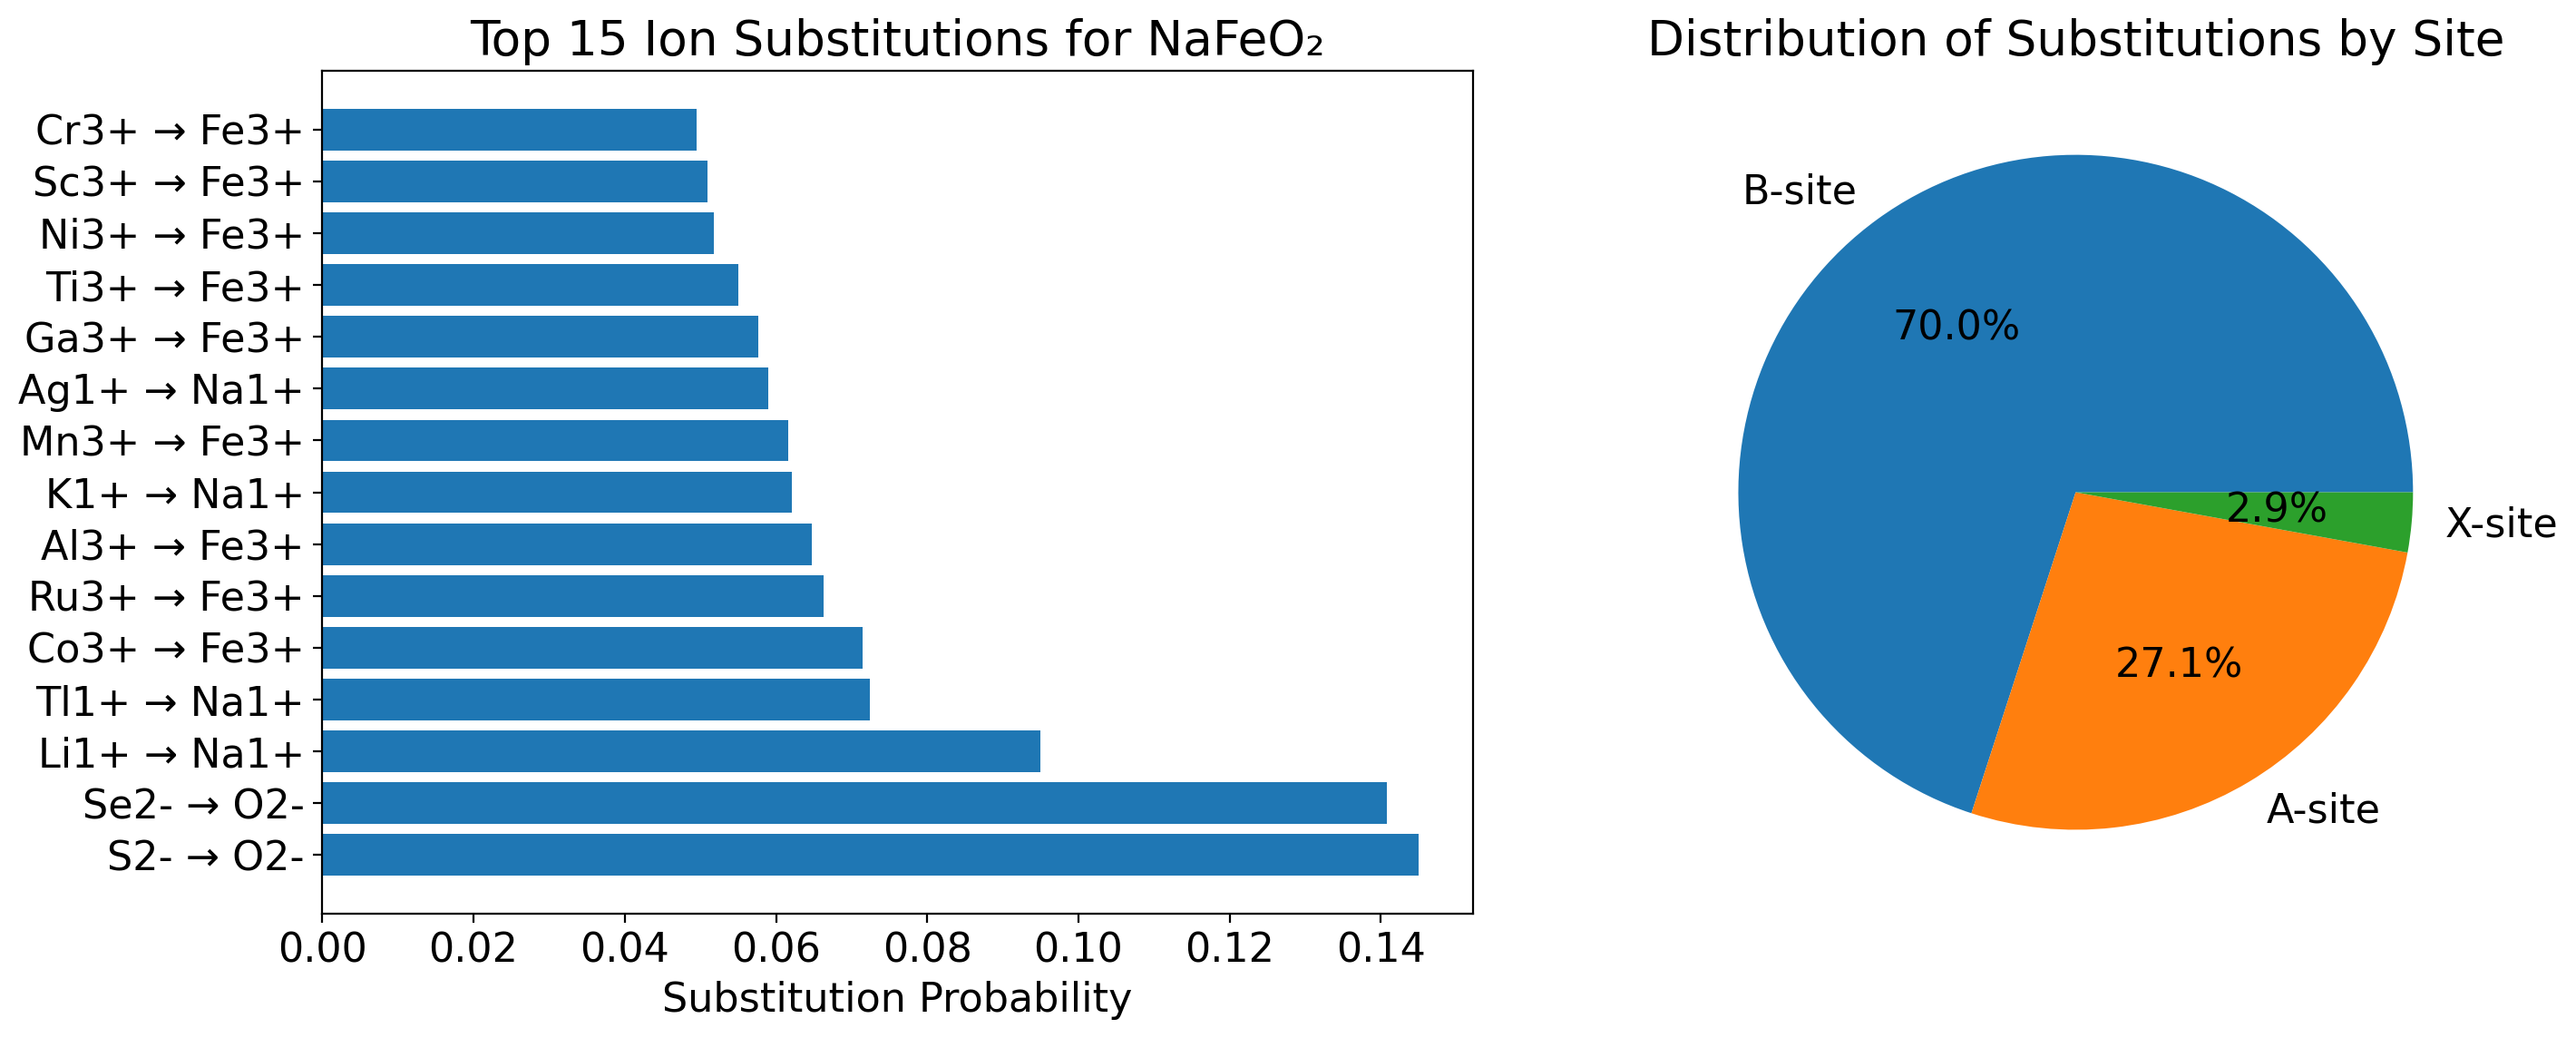

✓ Visualization complete

 Visualising original vs most probable substitution:


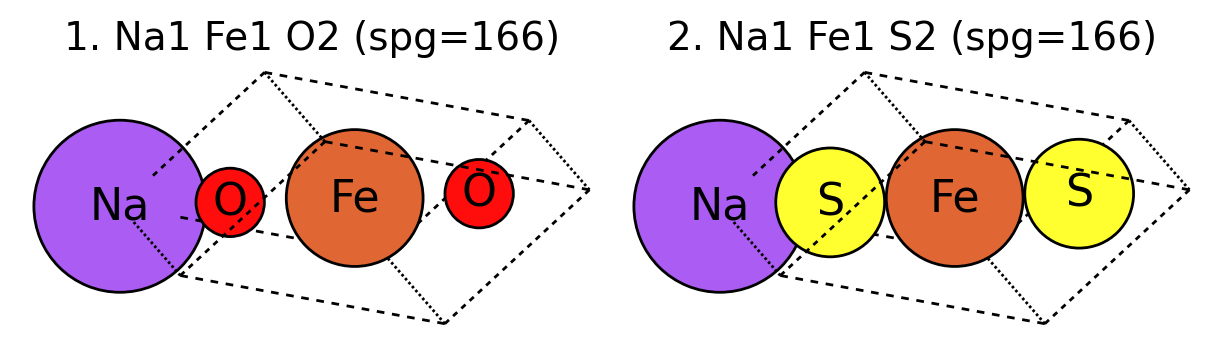

✓ Structure comparison complete


In [ ]:
print_section_header("PART 2: ION SUBSTITUTION WITH CATIONMUTATOR")

# Initialise the CationMutator
print("Loading CationMutator with pymatgen lambda table...")
mutator = CationMutator.from_json()
print("✓ CationMutator loaded successfully")

# Substitution examples (tailored for SIB context)
print("\nSubstitution probability examples:")
print("-" * 60)

test_pairs = [
    ("Na1+", "K1+", "alkali metals - similar size/charge"),
    ("Fe3+", "Mn3+", "similar transition metals - likely"),
    ("Na1+", "Mg2+", "different charge - unlikely"),
    ("Fe3+", "Al3+", "different d-block behavior - moderate")
]

for ion1, ion2, description in test_pairs:
    prob = mutator.sub_prob(ion1, ion2)
    print(f"{ion1:>6s} → {ion2:<6s}: {prob:.4g} ({description})")

print("\n💡 Higher probability = more chemically reasonable substitution!")

# Generate substitution candidates
print("\n Generating substitution candidates for NaFeO₂...")
print("(Using probability threshold of 0.001)")

candidate_structures = list(mutator.unary_substitute(nafeo2_sstruct, thresh=0.001))
print(f"\n✓ Found {len(candidate_structures)} possible substitutions!")

# Analyse the results
if candidate_structures:
    print("\nTop 5 most probable substitutions:")
    print("-" * 60)

    sorted_candidates = sorted(candidate_structures, key=lambda x: x[1], reverse=True)

    for i, (struct, prob, orig, new) in enumerate(sorted_candidates[:5]):
        print(f"{i+1:2d}. {new:>6s} → {orig:<6s}: p={prob:.3f}")
        print(f"     New formula: {struct.reduced_formula()}")

    # Detailed DataFrame Analysis
    print("\n Creating detailed substitution analysis...")
    site_map = {"Na1+": "A-site", "Fe3+": "B-site", "O2-": "X-site"}

    analysis_data = []
    for struct, prob, orig, new in candidate_structures:
        analysis_data.append({
            'Original Ion': orig,
            'Substitute Ion': new,
            'Probability': prob,
            'New Formula': struct.reduced_formula(),
            'Site Type': site_map.get(orig, "Unknown")
        })

    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis.sort_values('Probability', ascending=False).reset_index(drop=True)

    print("\n Substitution analysis by site:")
    print("=" * 70)
    for orig_ion in df_analysis['Original Ion'].unique():
        subset = df_analysis[df_analysis['Original Ion'] == orig_ion]
        site_type = subset.iloc[0]['Site Type']
        print(f"\n{site_type} - Top 3 substitutions for {orig_ion}:")
        for _, row in subset.head(3).iterrows():
            print(f"  {row['Substitute Ion']:>6s} → {row['New Formula']:>12s} (p={row['Probability']:.3f})")

    # Visualise substitution probabilities
    try:
        print("\n Creating substitution probability visualization...")
        top_15 = df_analysis.head(15)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.barh(range(len(top_15)), top_15['Probability'])
        ax1.set_yticks(range(len(top_15)))
        ax1.set_yticklabels([f"{row['Substitute Ion']} → {row['Original Ion']}"
                            for _, row in top_15.iterrows()])
        ax1.set_xlabel('Substitution Probability')
        ax1.set_title('Top 15 Ion Substitutions for NaFeO₂')

        site_counts = df_analysis['Site Type'].value_counts()
        ax2.pie(site_counts.values, labels=site_counts.index, autopct='%1.1f%%')
        ax2.set_title('Distribution of Substitutions by Site')

        plt.tight_layout()
        plt.show()
        print("✓ Visualization complete")
    except Exception as e:
        print(f"⚠ Could not create plots: {e}")

    # Visualise structures if pymatviz is available
    if pymatviz_available:
        try:
            print("\n Visualising original vs most probable substitution:")
            top_struct = sorted_candidates[0][0]
            pmv.structure_2d([nafeo2_sstruct.as_py_struct(), top_struct.as_py_struct()])
            plt.show()
            print("✓ Structure comparison complete")
        except Exception as e:
            print(f"⚠ Could not visualise structures: {e}")


In [ ]:
import smact.structure_prediction.mutation
print(dir(smact.structure_prediction.mutation))

['CationMutator', 'TYPE_CHECKING', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'annotations', 'deepcopy', 'itemgetter', 'itertools', 'json', 'np', 'os', 'parse_spec', 'pd', 'pymatgen_sp']



PART 3: STRUCTURE DATABASE MANAGEMENT
Setting up structure database...
✓ Created database 'nafe_tutorial_structures.db' with table 'na_cathodes'

Adding structures to database...
  - Added NaFeO₂ (original structure)
  - Added 10 substitution variants

📦 Local database 'na_cathodes': 11 structures

🔍 Querying database for specific species...
--------------------------------------------------

Structures containing Na⁺: 11
  - NaFeO2
  - NaAgO2
  - NaAlO2

Structures containing both Na⁺ and Fe³⁺: 1

🧪 Analysing anion distribution in Na-based cathodes...


/tmp/ipython-input-88-387387708.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


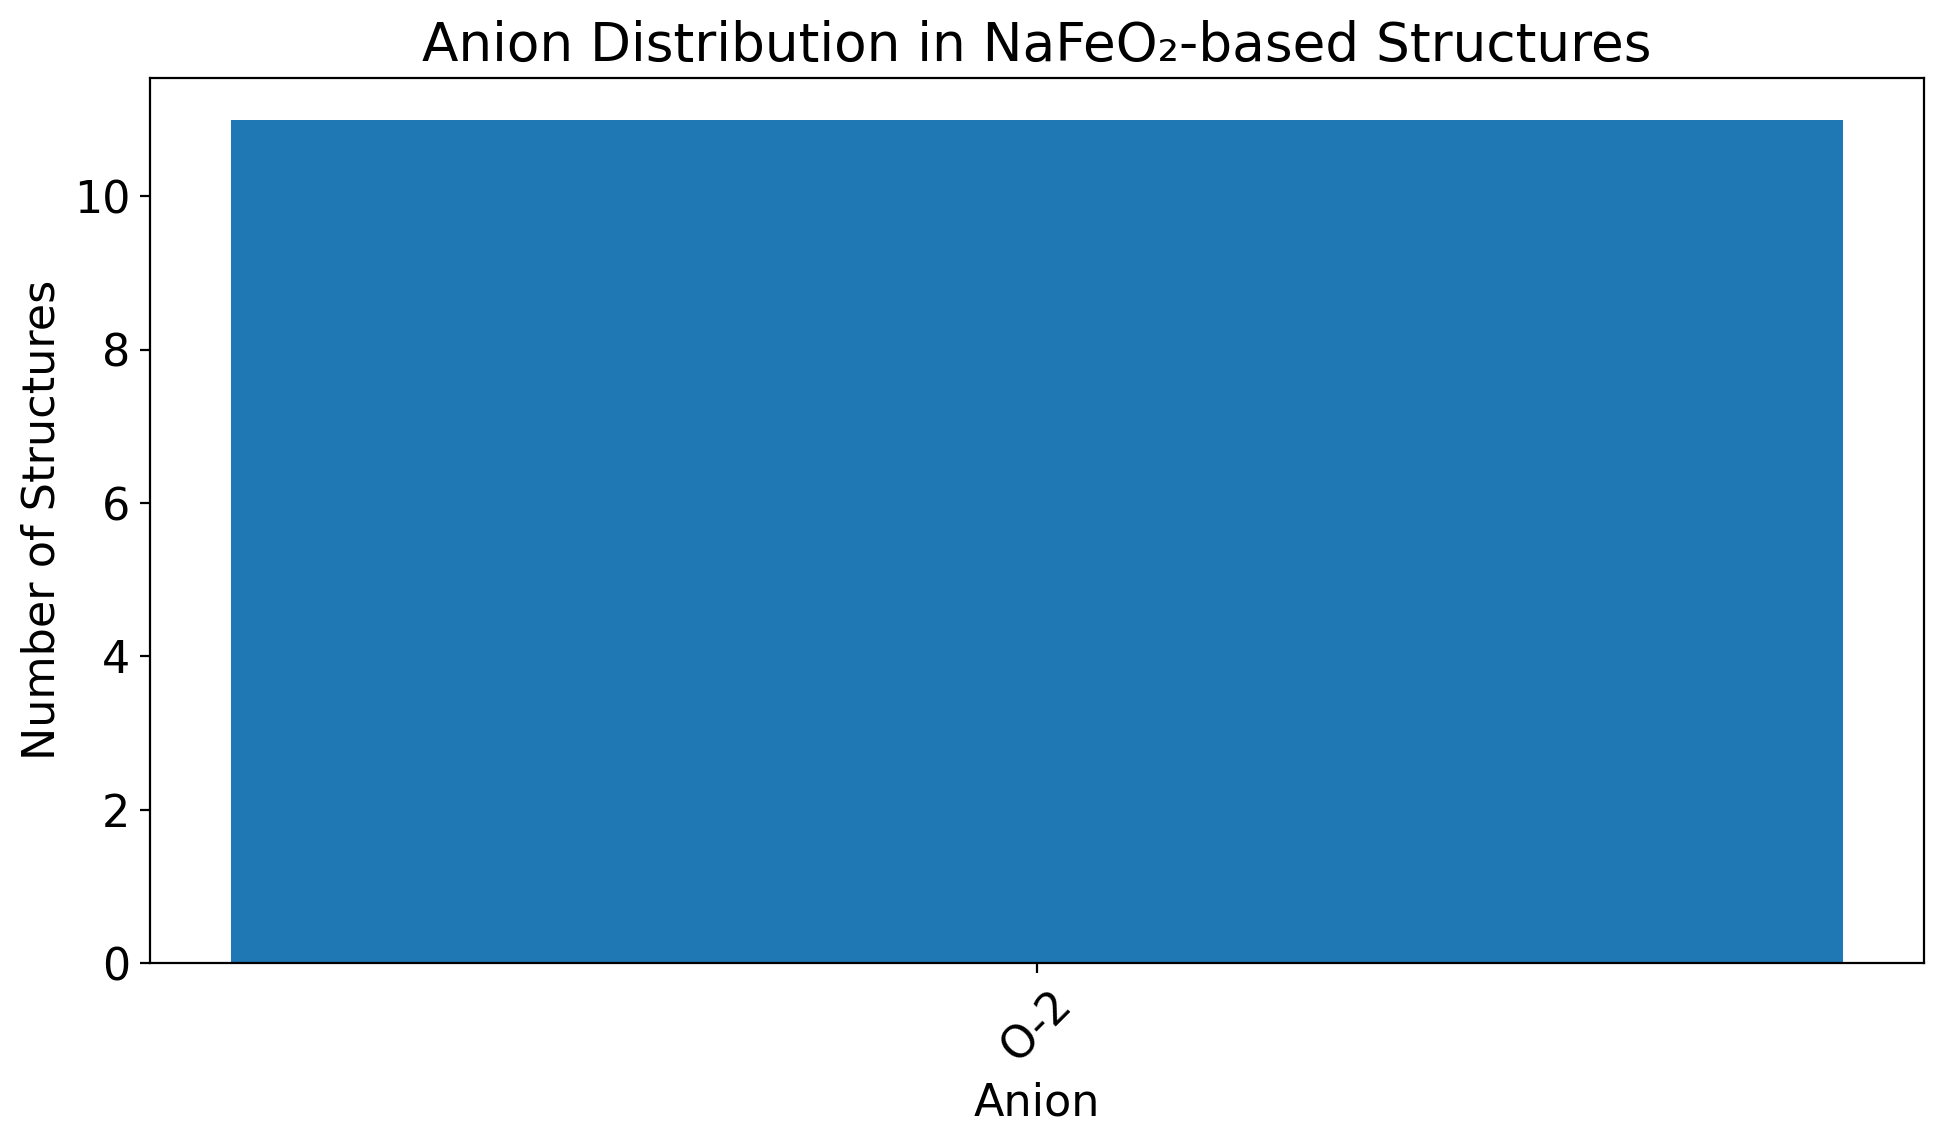

✓ Anion distribution analysis complete


In [ ]:
print_section_header("PART 3: STRUCTURE DATABASE MANAGEMENT")

# Create a structure database
print("Setting up structure database...")

db_filename = "nafe_tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database and table
db = StructureDB(db_filename)
table_name = "na_cathodes"
db.add_table(table_name)

print(f"✓ Created database '{db_filename}' with table '{table_name}'")

# Add base structure
print("\nAdding structures to database...")
db.add_struct(nafeo2_sstruct, table=table_name)
print("  - Added NaFeO₂ (original structure)")

# Add substitution variants
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]
    num_added = db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {num_added} substitution variants")

# Summary count
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    local_count = c.fetchone()[0]
    print(f"\n📦 Local database '{table_name}': {local_count} structures")

# Query structures containing specific species
print("\n🔍 Querying database for specific species...")
print("-" * 50)

# Structures containing Na+
na_structures = db.get_with_species(species=[("Na", 1)], table=table_name)
print(f"\nStructures containing Na⁺: {len(na_structures)}")
for struct in na_structures[:3]:
    print(f"  - {struct.reduced_formula()}")

# Structures with both Na+ and Fe3+
na_fe_structures = db.get_with_species(species=[("Na", 1), ("Fe", 3)], table=table_name)
print(f"\nStructures containing both Na⁺ and Fe³⁺: {len(na_fe_structures)}")

# Anion analysis (optional)
print("\n🧪 Analysing anion distribution in Na-based cathodes...")
anions = [("O", -2), ("F", -1), ("Cl", -1), ("S", -2), ("N", -3)]
anion_counts = {}

for anion_name, ox_state in anions:
    try:
        count = len(db.get_with_species([(anion_name, ox_state)], table=table_name))
        if count > 0:
            anion_counts[f"{anion_name}{ox_state:+d}"] = count
    except Exception as e:
        print(f"Error querying {anion_name}{ox_state:+d}: {e}")

if anion_counts:
    plt.figure(figsize=(10, 6))
    plt.bar(anion_counts.keys(), anion_counts.values())
    plt.xlabel("Anion")
    plt.ylabel("Number of Structures")
    plt.title("Anion Distribution in NaFeO₂-based Structures")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("✓ Anion distribution analysis complete")
else:
    print("No anions found in current database.")


In [ ]:
print_section_header("PART 4: STRUCTURE PREDICTION FROM COMPOSITION")

# Use your database and mutator
print(f"Initialising structure predictor with '{table_name}' database...")
predictor = StructurePredictor(
    mutator=mutator,
    struct_db=db,
    table=table_name
)

# Define new target Na-based cathode compositions (customize as needed)
target_compositions = [
    ([("Na", 1), ("Mn", 3), ("O", -2)], "NaMnO₂"),
    ([("Na", 1), ("Co", 3), ("O", -2)], "NaCoO₂"),
    ([("Na", 1), ("Ni", 3), ("O", -2)], "NaNiO₂")
]

print("\n Testing structure prediction for new Na-cathode compositions...")

for target_species, formula in target_compositions:
    print(f"\n--- Target composition: {formula} ---")

    threshold = 0.001
    results = list(predictor.predict_structs(
        species=target_species,
        thresh=threshold,
        include_same=False
    ))

    print(f"Found {len(results)} candidate structures!")

    if results:
        # Sort by probability
        results.sort(key=itemgetter(1), reverse=True)

        print("Top predictions:")
        for i, (pred_struct, prob, parent_struct) in enumerate(results[:3]):
            print(f"  {i+1}. Parent: {parent_struct.reduced_formula()} → "
                  f"Predicted: {pred_struct.reduced_formula()} (p={prob:.3f})")

            # Substitutions
            parent_species = set(parent_struct.get_spec_strs())
            pred_species = set(pred_struct.get_spec_strs())
            subs_out = parent_species - pred_species
            subs_in = pred_species - parent_species
            if subs_out and subs_in:
                print(f"      Substitutions: {subs_out} → {subs_in}")
    else:
        print("   No predictions found - try lowering threshold or adding more structures")



PART 4: STRUCTURE PREDICTION FROM COMPOSITION
Initialising structure predictor with 'na_cathodes' database...

 Testing structure prediction for new Na-cathode compositions...

--- Target composition: NaMnO₂ ---
Found 6 candidate structures!
Top predictions:
  1. Parent: NaFeO2 → Predicted: NaMnO2 (p=0.029)
      Substitutions: {'Fe3+'} → {'Mn3+'}
  2. Parent: NaAlO2 → Predicted: NaMnO2 (p=0.020)
      Substitutions: {'Al3+'} → {'Mn3+'}
  3. Parent: NaAgO2 → Predicted: NaMnO2 (p=0.006)
      Substitutions: {'Ag3+'} → {'Mn3+'}

--- Target composition: NaCoO₂ ---
Found 10 candidate structures!
Top predictions:
  1. Parent: NaFeO2 → Predicted: NaCoO2 (p=0.022)
      Substitutions: {'Fe3+'} → {'Co3+'}
  2. Parent: NaAlO2 → Predicted: NaCoO2 (p=0.019)
      Substitutions: {'Al3+'} → {'Co3+'}
  3. Parent: NaBkO2 → Predicted: NaCoO2 (p=0.018)
      Substitutions: {'Bk3+'} → {'Co3+'}

--- Target composition: NaNiO₂ ---
Found 10 candidate structures!
Top predictions:
  1. Parent: NaBkO2 → Pred

In [ ]:
print_section_header("PART 5: ADVANCED ANALYSIS AND INSIGHTS")

# Ensure we have substitution candidates
if candidate_structures:
    print("🧠 Ion substitution insights:")

    # Classify substitutions by target ion
    a_site_subs = [c for c in candidate_structures if c[2] == 'Na1+']
    b_site_subs = [c for c in candidate_structures if c[2] == 'Fe3+']
    x_site_subs = [c for c in candidate_structures if c[2] == 'O2-']

    print(f"- A-site (Na⁺) substitutions: {len(a_site_subs)}")
    print(f"- B-site (Fe³⁺) substitutions: {len(b_site_subs)}")
    print(f"- X-site (O²⁻) substitutions: {len(x_site_subs)}")

    # Most probable substitutions for each site
    if a_site_subs:
        best_a = max(a_site_subs, key=lambda x: x[1])
        print(f"- Best A-site substitution: {best_a[3]} → Na1+ (p={best_a[1]:.3f})")

    if b_site_subs:
        best_b = max(b_site_subs, key=lambda x: x[1])
        print(f"- Best B-site substitution: {best_b[3]} → Fe3+ (p={best_b[1]:.3f})")

    if x_site_subs:
        best_x = max(x_site_subs, key=lambda x: x[1])
        print(f"- Best X-site substitution: {best_x[3]} → O2- (p={best_x[1]:.3f})")

# Summary insights
print("\nChemical insights from this NaFeO₂ study:")
print("1. Monovalent cations (e.g. Li⁺, K⁺) may substitute for Na⁺ depending on size/chemistry")
print("2. Transition metals (e.g. Mn³⁺, Co³⁺) may substitute for Fe³⁺ in B-site")
print("3. Oxygen (O²⁻) is often fixed, but other anions (S²⁻, F⁻) might substitute in extended cases")
print("4. Substitution success depends on radius, charge, and crystal environment")
print("5. Using structure databases enables discovery of chemically plausible new cathode materials")



PART 5: ADVANCED ANALYSIS AND INSIGHTS
🧠 Ion substitution insights:
- A-site (Na⁺) substitutions: 19
- B-site (Fe³⁺) substitutions: 49
- X-site (O²⁻) substitutions: 2
- Best A-site substitution: Li1+ → Na1+ (p=0.095)
- Best B-site substitution: Co3+ → Fe3+ (p=0.071)
- Best X-site substitution: S2- → O2- (p=0.145)

Chemical insights from this NaFeO₂ study:
1. Monovalent cations (e.g. Li⁺, K⁺) may substitute for Na⁺ depending on size/chemistry
2. Transition metals (e.g. Mn³⁺, Co³⁺) may substitute for Fe³⁺ in B-site
3. Oxygen (O²⁻) is often fixed, but other anions (S²⁻, F⁻) might substitute in extended cases
4. Substitution success depends on radius, charge, and crystal environment
5. Using structure databases enables discovery of chemically plausible new cathode materials
